In [1]:
import fastdyn_fic_dmf as dmf
from scipy.signal import butter, lfilter
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_multitaper

def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    print(fcd.shape)
    print(data.shape)
    print((data[win_start[2]:win_start[2] + wsize + 1, :]).shape)
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


## Homeostatic grid seacrch


In [14]:
nb_steps = 100000
C = loadmat('../SC_and_5ht2a_receptors.mat')['sc90']
C = 0.2*C/np.max(C)
brunout = 5
params = dmf.default_params(C=C)
params['N'] = C.shape[0]
params['seed'] = 2
G_max = 6
DECAY_max = 60000
OBJ_RATE_max = 15
#G_step = 0.1
#DECAY_step = 0.2
G_step = 2
DECAY_step = 20000
OBJ_RATE_step = 3
G_range = np.arange(0,G_max,G_step)
DECAY_range = [100,10000,60000]#np.arange(1,DECAY_max,DECAY_step)
OBJ_RATE_range = np.arange(1,OBJ_RATE_max,OBJ_RATE_step)
amount_slow_regions_grid = np.zeros((len(G_range), len(DECAY_range),len(OBJ_RATE_range)))
mean_slow_grid = np.zeros((len(G_range), len(DECAY_range),len(OBJ_RATE_range)))
std_slow_grid = np.zeros((len(G_range), len(DECAY_range),len(OBJ_RATE_range)))
homeostatic_fittness_grid = np.zeros((len(G_range), len(DECAY_range),len(OBJ_RATE_range)))
rates_grid,rates_inh_grid, bold_grid, fic_t_grid = np.zeros((len(G_range),len(DECAY_range),len(OBJ_RATE_range),N,nb_steps)),np.zeros((len(G_range),len(DECAY_range),len(OBJ_RATE_range),N,nb_steps)),np.zeros((len(G_range),len(DECAY_range),len(OBJ_RATE_range),N,nb_steps)),np.zeros((len(G_range),len(DECAY_range),len(OBJ_RATE_range),N,nb_steps))
for idx_G,G in enumerate(G_range):
    for idx_DECAY,DECAY in enumerate(DECAY_range):
        for idx_OBJ_RATE,OBJ_RATE in enumerate(OBJ_RATE_range):
            params['lrj'] = 1
            params['G'] = G
            params['taoj'] = DECAY
            params['obj_rate'] = OBJ_RATE
            #params['taoj'] = 210000
            params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
            N = C.shape[0]
            tracemalloc.start()
            rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps,return_rate=True, return_bold=True, return_fic=True)
            rates_grid[idx_G, idx_DECAY,idx_OBJ_RATE] = rates
            rates_inh_grid[idx_G, idx_DECAY,idx_OBJ_RATE] = rates_inh
            #bold_grid[idx_G, idx_DECAY,idx_OBJ_RATE] = bold
            fic_t_grid[idx_G, idx_DECAY,idx_OBJ_RATE] = fic_t
            # Slicing and computations
            bold = bold[:, (np.ceil(brunout / params['TR'])).astype(int):]
            rates = rates[:, np.ceil(brunout * 1000).astype(int):]
            rates_inh = rates_inh[:, np.ceil(brunout * 1000).astype(int):]
            fic_t = fic_t[:, np.ceil(brunout * 1000).astype(int):]
            sampling_freq = 10000  
            power_spectrum,frequencies = psd_array_multitaper(rates, sfreq=sampling_freq, fmin=0, fmax=100,bandwidth=32*(sampling_freq/rates.shape[1]))
            plow_ptot = np.sum(power_spectrum[:, :39], axis=1)/np.sum(power_spectrum[:,:], axis=1)
            amount_slow_regions = np.sum(plow_ptot>0.3)
            mean_slow = np.mean(plow_ptot)
            std_slow = np.std(plow_ptot)
            homeostatic_fittness =  OBJ_RATE - np.mean(rates)  #if not np.isnan(np.mean(rates)) else 0
            amount_slow_regions_grid[idx_G, idx_DECAY,idx_OBJ_RATE] = amount_slow_regions
            mean_slow_grid[idx_G, idx_DECAY,idx_OBJ_RATE] = mean_slow
            std_slow_grid[idx_G, idx_DECAY,idx_OBJ_RATE] = std_slow
            homeostatic_fittness_grid[idx_G, idx_DECAY,idx_OBJ_RATE] = homeostatic_fittness

Calling run
Ending beautiful simulation has option 2     Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending beautiful simulation has option 2     Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending beautiful simulation has option 2     Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending beautiful simulation has option 2     Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending beautiful simulation has option 2     Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending beautiful simulation has option 2     Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending beautiful simulation has option 2     Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending beautiful simulation has option 2     Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending beautiful simulation has option 2     Using multitaper spectr

In [15]:
np.save("../Results/HomeostaticGrid/rates.npy", rates_grid)
np.save("../Results/HomeostaticGrid/fic_t.npy", fic_t_grid)
np.save("../Results/HomeostaticGrid/rates_inh.npy", rates_inh_grid)


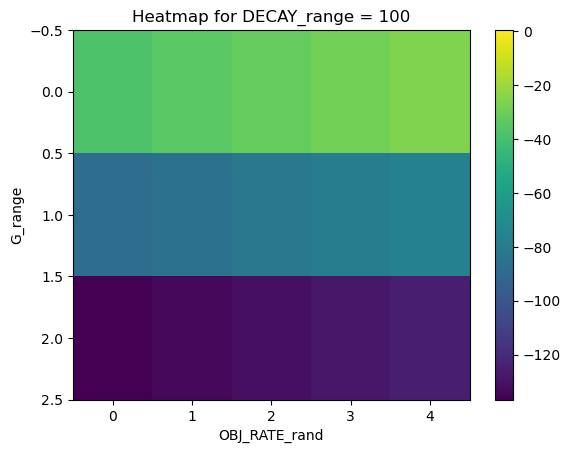

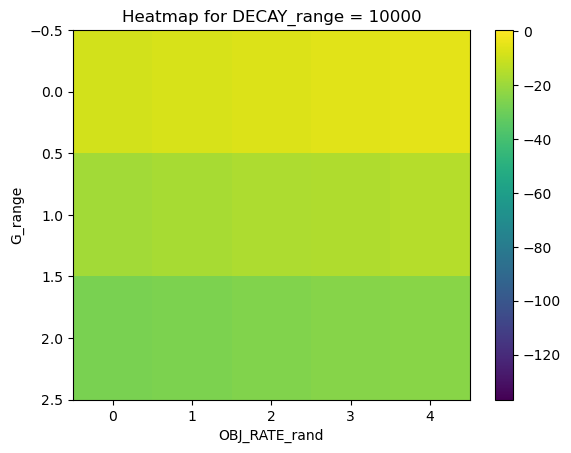

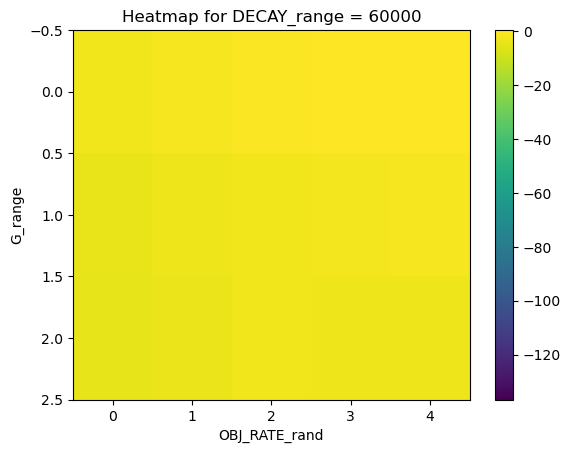

In [24]:
import matplotlib.pyplot as plt

for i, decay_value in enumerate(DECAY_range):
    fig, ax = plt.subplots()
    
    # Extracting the corresponding slice from homeostatic_fittness_grid
    slice_data = homeostatic_fittness_grid[:, i,:]
    
    # Plotting the heatmap
    heatmap = ax.imshow(slice_data, cmap='viridis', aspect='auto', vmin=np.min(homeostatic_fittness_grid), vmax=np.max(homeostatic_fittness_grid))
    plt.colorbar(heatmap, ax=ax)
    
    ax.set_xlabel('OBJ_RATE_rand')
    ax.set_ylabel('G_range')
    ax.set_title(f'Heatmap for DECAY_range = {decay_value}')
    
    plt.show()


In [23]:
OBJ_RATE - np.mean(rates)

-124.84197283672313

In [7]:
DECAY_range

[100, 10000, 60000]

In [8]:
G_range

array([0, 2, 4])

In [9]:
OBJ_RATE_range

array([ 1,  4,  7, 10, 13])

In [12]:
bold.shape

(90, 19)

(4005, 119)
(150, 90)
(31, 90)
    Using multitaper spectrum estimation with 30 DPSS windows


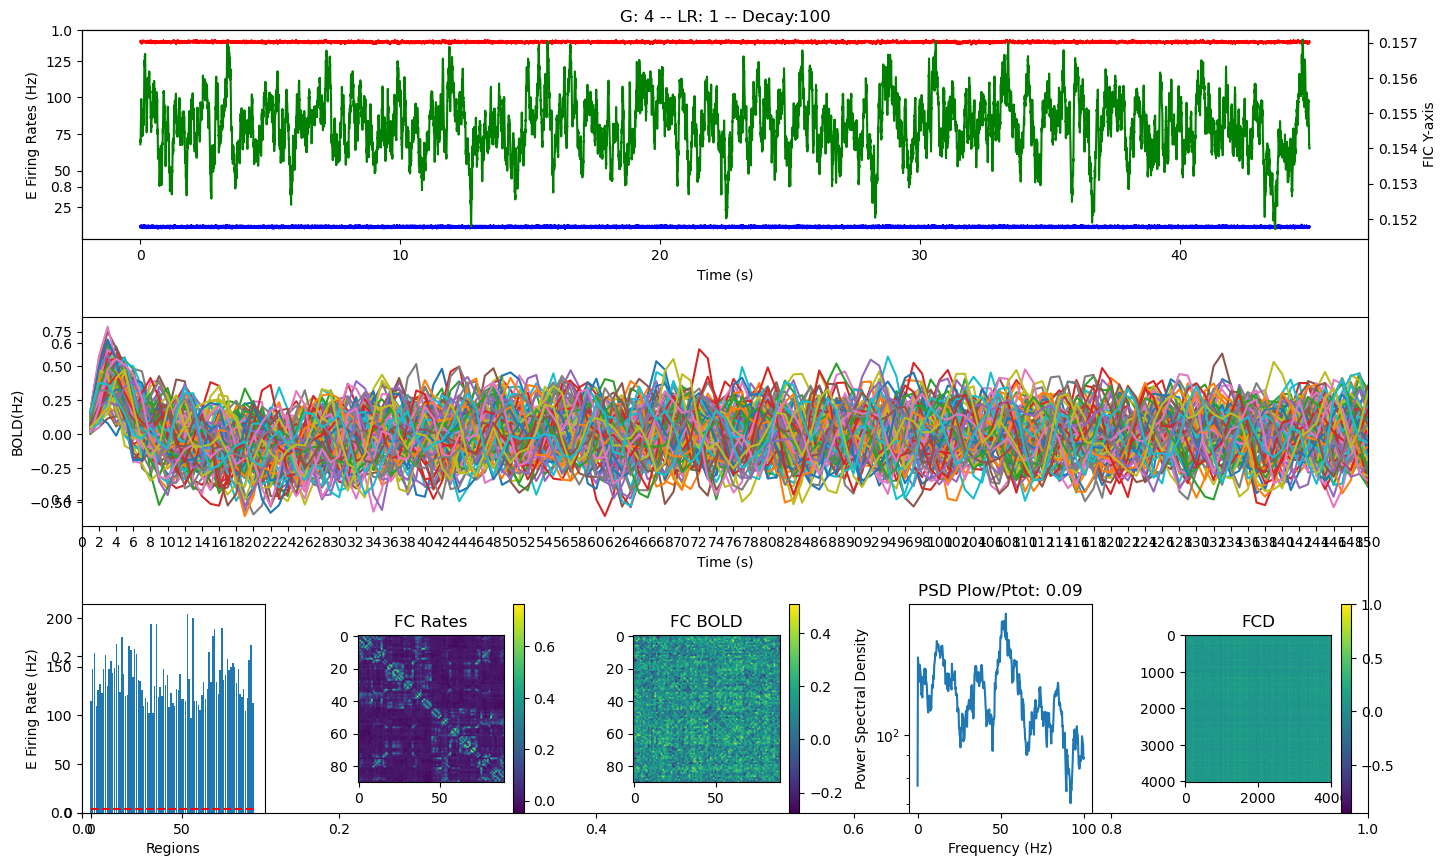

In [22]:
nb_steps = 100000
C = loadmat('../SC_and_5ht2a_receptors.mat')['sc90']
C = 0.2*C/np.max(C)
params = dmf.default_params(C=C)

idx_G = 2
idx_OBJ_RATE = 1
idx_DECAY = 0

params['seed'] = 2
params['G'] = G_range[idx_G]
params['lrj'] = 1
params['obj_rate'] = OBJ_RATE_range[idx_OBJ_RATE]
params['taoj'] = DECAY_range[idx_DECAY]
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
N = C.shape[0]

with_decay = True
with_plasticity = True
#rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps,return_rate=True, return_bold=True, return_fic=True, with_plasticity=with_plasticity, with_decay=with_decay)
# displaying the memory
rates = rates_grid[idx_G, idx_DECAY, idx_OBJ_RATE]
rates_inh = rates_inh_grid[idx_G, idx_DECAY, idx_OBJ_RATE]
fic_t = fic_t_grid[idx_G, idx_DECAY, idx_OBJ_RATE]
brunout = 5
# Slicing and computations
bold = np.random.rand(N, 150)# bold[:, (np.ceil(brunout / params['TR'])).astype(int):]
rates = rates[:, np.ceil(brunout * 1000).astype(int):]
rates_inh = rates_inh[:, np.ceil(brunout * 1000).astype(int):]
fic_t = fic_t[:, np.ceil(brunout * 1000).astype(int):]
rates_fc = np.corrcoef(rates)
rates_inh_fc = np.corrcoef(rates_inh)
T = len(bold.T)
isubfcd = np.triu_indices(C.shape[1],1)
flp = 0.01
fhp = 0.1
wsize = 30
overlap = 29
win_start = np.arange(0, T - wsize, wsize - overlap)
nwins = len(win_start)
nints = len(isubfcd[0])
b,a = butter(2,np.array([0.01, 0.1])*2*params['TR'], btype='band')
filt_bold = lfilter(b,a,bold)
time_fc = compute_fcd(filt_bold.T, wsize, overlap, isubfcd)
# Replace 'compute_fcd' with the appropriate function or code that computes time_fc
bold_fc = np.corrcoef(filt_bold)
fcd = np.corrcoef(time_fc)
mean_fic_dist = np.zeros(N)
for n in range(N):
    data = fic_t[:, n]
    mean_fic_dist[n] = np.mean(data)


# Assuming 'rates' is your firing rates variable
sampling_freq = 10000  # Replace with your actual sampling frequency (e.g., 1000 Hz)
# Calculate the power spectral density using multitaper method
power_spectrum,frequencies = psd_array_multitaper(rates, sfreq=sampling_freq, fmin=0, fmax=100,bandwidth=32*(sampling_freq/rates.shape[1]))

fig = plt.figure(figsize=(15, 9))
#plt.title(f"G: {G_range[obs_idx_G]} -- LR: {LR_range[obs_idx_LR]}")
plt.title(f"G: {params['G']} -- LR: {params['lrj'] if with_plasticity else 'No plasticity '} -- Decay:{params['taoj'] if with_decay else 'No decay'}")
sel_t = np.arange(1, rates.shape[1] + 1)
sel_t_bold = np.arange(1, bold.shape[1] + 1)
plt.subplot(3, 1, 1)
plt.plot(sel_t * 0.001, np.mean(rates_inh, axis=0), 'b')
plt.plot(sel_t * 0.001, np.mean(rates, axis=0), 'r')
plt.xlabel('Time (s)')
plt.ylabel('E Firing Rates (Hz)')
plt.twinx()
plt.plot(sel_t * 0.001, np.mean(fic_t, axis=0), color=[0, 0.5, 0])
plt.ylabel('FIC Y-axis')


plt.subplot(3, 1,2)
plt.plot(sel_t_bold, filt_bold.T)
plt.xticks((sel_t_bold - 1) * params['TR'])
plt.xlim([0, sel_t_bold[-1]])
plt.xlabel('Time (s)')
plt.ylabel('BOLD(Hz)')

plt.subplot(3, 5, 11)
plt.bar(np.arange(N), np.mean(rates, axis=1), edgecolor='none')
plt.plot([0, N + 1], [params['obj_rate'], params['obj_rate']], 'r--')
plt.ylabel('E Firing Rate (Hz)')
plt.xlabel('Regions')

plt.subplot(3, 5, 12)
plt.imshow(rates_fc - np.eye(N))
plt.title('FC Rates')
plt.colorbar()

plt.subplot(3, 5, 13)
# Assuming 'bold_fc' is defined
plt.imshow(bold_fc - np.eye(N))
plt.title('FC BOLD')
plt.colorbar()

plt.subplot(3, 5, 14)
plt.semilogy(frequencies, power_spectrum[0,:])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title(f'PSD Plow/Ptot: {np.sum(power_spectrum[0, :39])/np.sum(power_spectrum[0,:]):.2f}')

plt.subplot(3, 5, 15)
plt.imshow(fcd)
plt.title('FCD')
plt.colorbar()

plt.tight_layout()
plt.show()
